In [4]:
import seaborn as sns
import pandas as pd

In [5]:
import os
import tensorflow as tf
import numpy as np
import cv2
import time
import tifffile
import matplotlib.pyplot as plt
!pip install sewar
from PIL import Image
import skimage.measure  
import skimage.measure
import pywt
from math import log10, sqrt
import cv2
import numpy as np
from sewar.full_ref import mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb 

from sklearn.decomposition import PCA
  



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir('/content/drive/MyDrive/ProjectWork')

In [8]:
def read_img(pan_test_path, ms_test_path, img_name, FLAGS):
    pan_img_path=os.path.join(pan_test_path, img_name)
    ms_img_path=os.path.join(ms_test_path, img_name)
    #pan_img=cv2.imread(pan_img_path, -1)
    #pan_img=gdal_read(pan_img_path,'pan')
    pan_img=read8bit(pan_img_path,'pan')
    h,w=pan_img.shape
    pan_img=pan_img.reshape((1,h,w,1))
    #ms_img=cv2.imread(ms_img_path, -1)
    #ms_img=gdal_read(ms_img_path,'ms')
    ms_img=read8bit(ms_img_path,'ms')
    h,w,c=ms_img.shape
    ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    h,w,c=ms_img.shape
    
    # ms_img=np.array(ms_img)
    # h,w,c=ms_img.shape
    # ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    ms_img=ms_img.reshape((1,h,w,c))
   
    return pan_img, ms_img


In [9]:
def gdal_read(path,name):
    data=gdal.Open(path)
    w=data.RasterXSize
    h=data.RasterYSize
    img=data.ReadAsArray(0,0,w,h)
    if name == 'ms':
        img=np.transpose(img,(1,2,0))
    img=(img-1023.5)/1023.5
    return img


In [10]:
def read8bit(path,name):
    if name=='ms':
        v='src'
    else:
        v='pan'
    v='I'
    #img=scio.loadmat(path)[v]
    img=np.load(path)
    img=(img-127.5)/127.5
    return img


In [11]:
def img_write(img_array,save_path):
    datatype=gdal.GDT_UInt16
    h,w,c=img_array.shape
    driver=gdal.GetDriverByName('GTiff')
    data=driver.Create(save_path, w, h, c, datatype)
    for i in range(c):
        data.GetRasterBand(i+1).WriteArray(img_array[:,:,i])
    del data


In [12]:
def display(pan,ms,fused,size=(18,6)):
    print("fused shape",fused.shape)
    titles = ['pan','MS band 0','MS band 1','MS band 2','MS band 3','Fused']
    fig,ax = plt.subplots(nrows=1,ncols=6,figsize=size)
    ax[0].imshow(pan[0], cmap= 'gray')
    ax[1].imshow(ms[0][:,:,0], cmap= 'gist_earth')
    ax[2].imshow(ms[0][:,:,1], cmap= 'gist_earth')
    ax[3].imshow(ms[0][:,:,2], cmap= 'gist_earth')
    ax[4].imshow(ms[0][:,:,3], cmap= 'gist_earth')
    ax[5].imshow(fused, cmap= 'gist_earth')
    for axis in ax:
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    for axis,title in zip(ax,titles):
        axis.set_title(title)
    plt.show()
    u_ms= uqi(ms[0][:,:,:3],fused)
    print('UQI fused/MS=' ,u_ms)
    u_pan= uqi(pan[0],fused[:,:,:1])
    print('UQI fused/PAN= ',u_pan)


In [13]:
os.listdir("data/test_gt_gf")  

['pan', 'hrms', 'lrms']

In [14]:
def display(pan,ms,fused,size=(18,6)):
    print("fused shape",fused.shape)
    titles = ['pan','MS band 0','MS band 1','MS band 2','MS band 3','Fused']
    fig,ax = plt.subplots(nrows=1,ncols=6,figsize=size)
    ax[0].imshow(pan[0], cmap= 'gray')
    ax[1].imshow(ms[0][:,:,0], cmap= 'gist_earth')
    ax[2].imshow(ms[0][:,:,1], cmap= 'gist_earth')
    ax[3].imshow(ms[0][:,:,2], cmap= 'gist_earth')
    ax[4].imshow(ms[0][:,:,3], cmap= 'gist_earth')
    ax[5].imshow(fused, cmap= 'gist_earth')
    for axis in ax:
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    for axis,title in zip(ax,titles):
        axis.set_title(title)
    plt.show()
    u_ms= uqi(ms[0][:,:,:3],fused)
    print('UQI fused/MS=' ,u_ms)
    u_pan= uqi(pan[0],fused[:,:,:1])
    print('UQI fused/PAN= ',u_pan)


image1

(408, 308, 3)
(408, 308)


<Figure size 432x432 with 0 Axes>

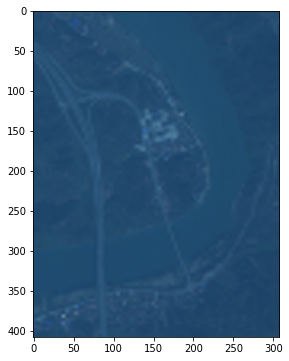

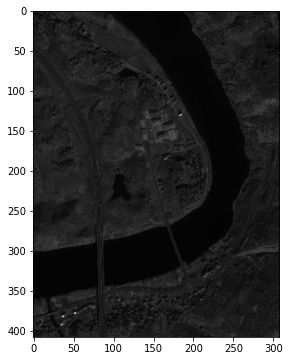

<Figure size 432x432 with 0 Axes>

In [15]:
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_8.npy',None)
ms0 = ms[0] 
ms0 = ms0*127.5+127.5
ms0 = ms0.astype('uint8')
ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(ms0)
print(ms0.shape)
pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
plt.figure(figsize=(6,6))
plt.imshow(pan0, cmap='gray')
print(pan0.shape)
plt.figure(figsize=(6,6))


PCA on ms

In [16]:
img = cv2.imread( '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/lrms/crop8bit_8.npy')

(408, 308, 3)


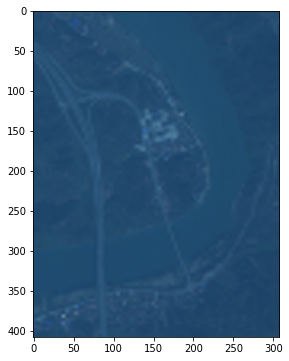

In [17]:
ms0 = ms[0] 
ms0 = ms0*127.5+127.5
ms0 = ms0.astype('uint8')
ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(ms0)
print(ms0.shape)


(408, 308)
1.0


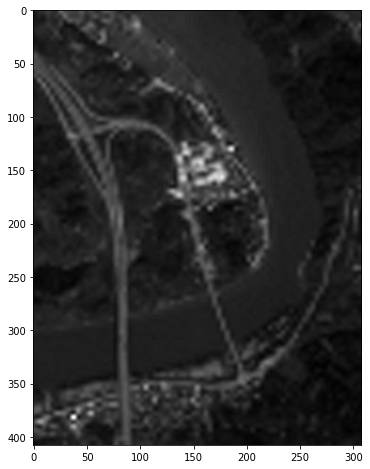

In [18]:
image_sum = ms0.sum(axis=2)
print(image_sum.shape)

image_bw = image_sum/image_sum.max()
print(image_bw.max())

plt.figure(figsize=[12,8])
plt.imshow(image_bw, cmap=plt.cm.gray)

Number of components explaining 95% variance: 28


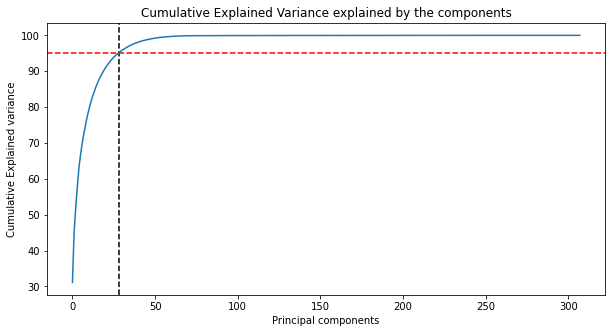

In [19]:
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA()
pca.fit(image_bw)

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

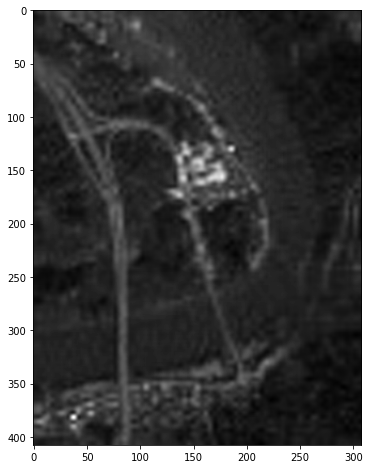

In [20]:
ipca = IncrementalPCA(n_components=k)
image_recon = ipca.inverse_transform(ipca.fit_transform(image_bw))

# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)

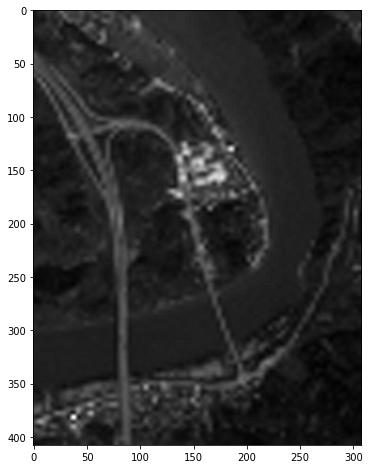

In [21]:
def plot_at_k(k):
    ipca = IncrementalPCA(n_components=k)
    image_recon = ipca.inverse_transform(ipca.fit_transform(image_bw))
    plt.imshow(image_recon,cmap = plt.cm.gray)
    

k = 250
plt.figure(figsize=[12,8])
plot_at_k(250)

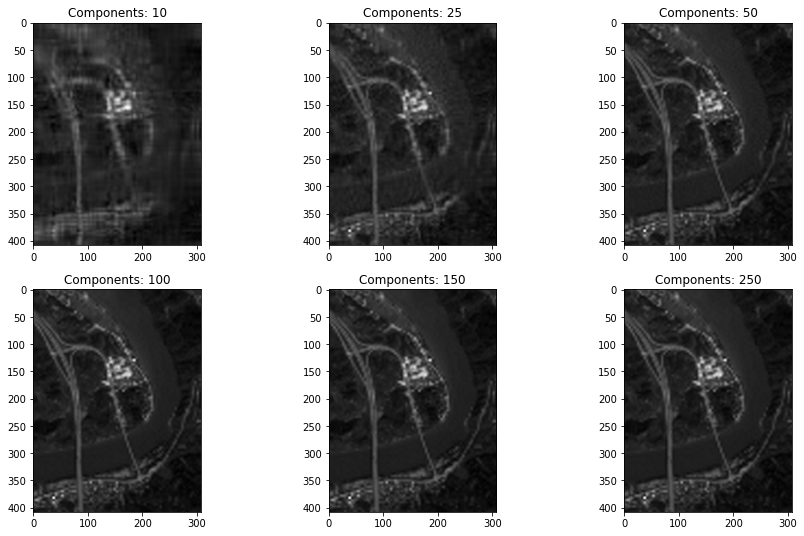

In [22]:
ks = [10, 25, 50, 100, 150, 250]

plt.figure(figsize=[15,9])

for i in range(6):
    plt.subplot(2,3,i+1)
    plot_at_k(ks[i])
    plt.title("Components: "+str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

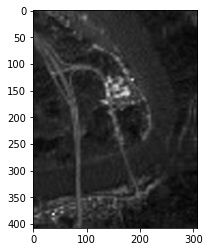

In [23]:
plt.imshow(image_recon, cmap= 'gray')

DWT on 1st coefficient of PCA

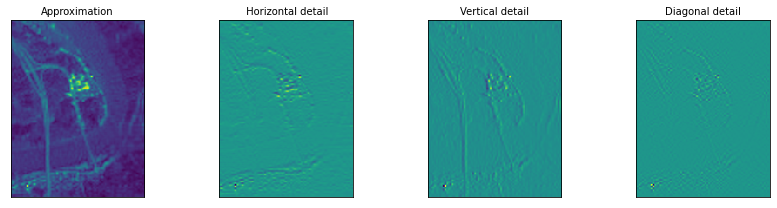

In [24]:
# Load image
original = image_recon
w='haar'

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, w)
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest")
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

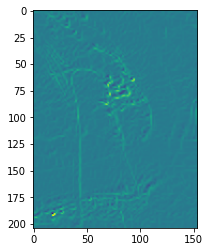

In [25]:
lowMS= np.maximum( LH, HL, HH)
plt.imshow(lowMS)

MHT on cD

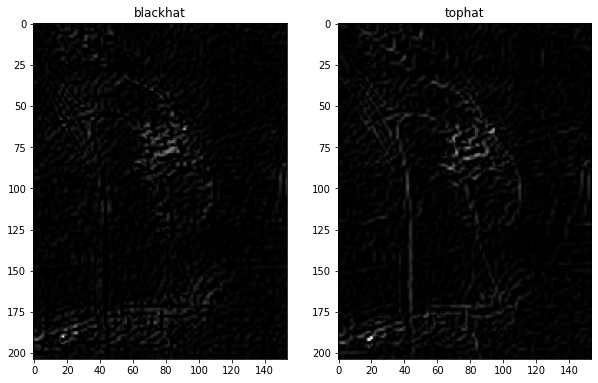

In [26]:
# Importing OpenCV
import cv2
filterSize =(5, 5)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,filterSize)
morphed_img_ms1=[]
#input_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blackhat_img = cv2.morphologyEx(lowMS,cv2.MORPH_BLACKHAT,kernel)
morphed_img_ms1.append(blackhat_img)

morphed_img_ms2=[]
#input_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
tophat_img = cv2.morphologyEx(lowMS,cv2.MORPH_TOPHAT,kernel)
morphed_img_ms2.append(tophat_img)


plt.figure(figsize=(10,9))

plt.subplot(121)
plt.title('blackhat')
plt.imshow( morphed_img_ms1[0],cmap= 'gray')
plt.subplot(122)
plt.title('tophat')    
plt.imshow( morphed_img_ms2[0],cmap='gray')



PCA on PAN

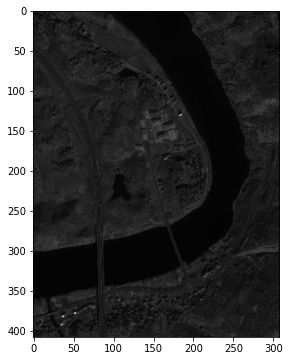

In [27]:

pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_8.npy',None)
pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
plt.figure(figsize=(6,6))
plt.imshow(pan0, cmap='gray')

Number of components explaining 95% variance: 113


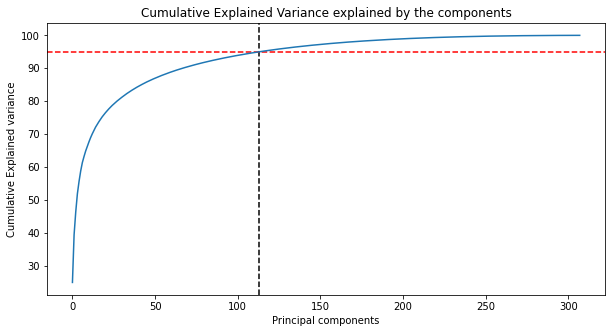

In [28]:
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA()
pca.fit(pan0)

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

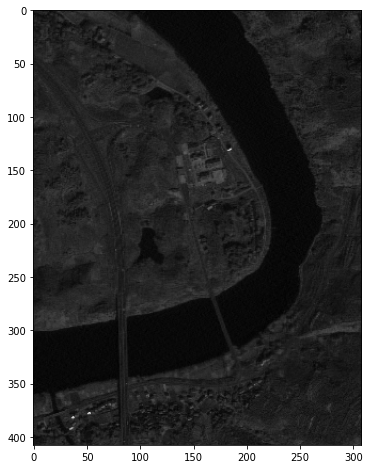

In [29]:
ipca = IncrementalPCA(n_components=k)
image_recon1 = ipca.inverse_transform(ipca.fit_transform(pan0))

# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon1,cmap = plt.cm.gray)

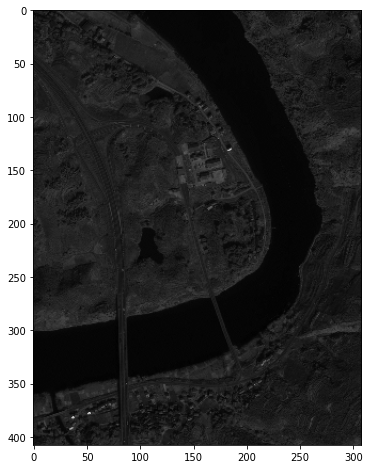

In [30]:
def plot_at_k(k):
    ipca = IncrementalPCA(n_components=k)
    image_recon1 = ipca.inverse_transform(ipca.fit_transform(pan0))
    plt.imshow(image_recon1,cmap = plt.cm.gray)
    

k = 250
plt.figure(figsize=[12,8])
plot_at_k(250)

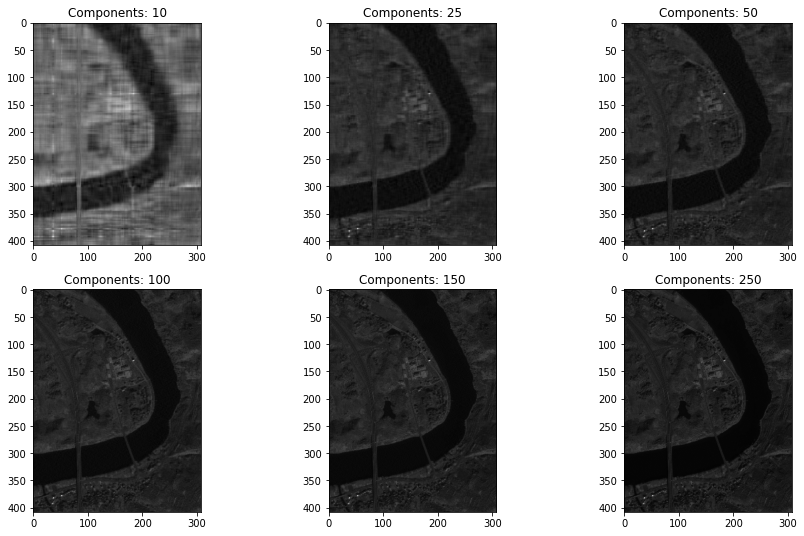

In [31]:
ks = [10, 25, 50, 100, 150, 250]

plt.figure(figsize=[15,9])

for i in range(6):
    plt.subplot(2,3,i+1)
    plot_at_k(ks[i])
    plt.title("Components: "+str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

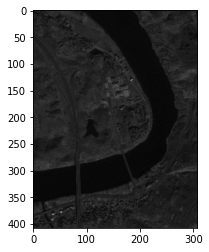

In [32]:
plt.imshow(image_recon1, cmap= 'gray')

DWT on PC of PAN

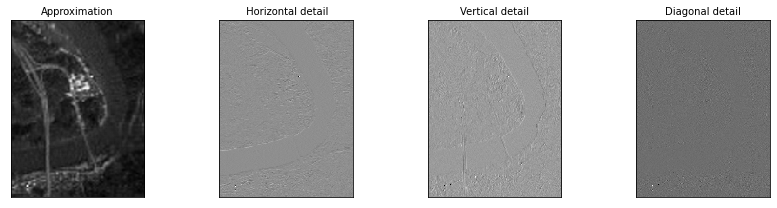

In [33]:
# Load image
original = image_recon1
w='haar'

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, w)
LL1, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest",cmap='gray')
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

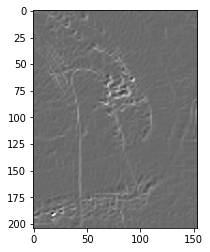

In [34]:
lowPAN= np.maximum( LH, HL, HH)
plt.imshow(lowMS, cmap='gray')

MHT on cD of PAN

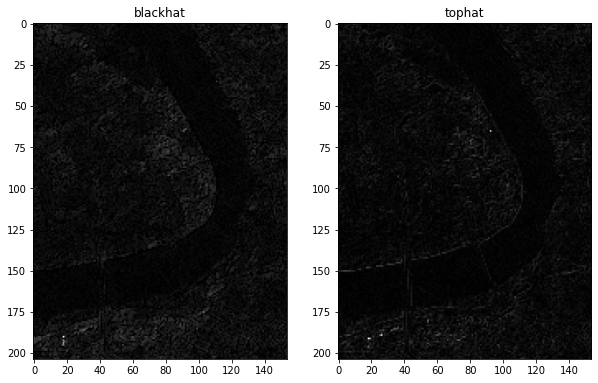

In [36]:
# Importing OpenCV
import cv2
filterSize =(5, 5)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)
morphed_img_pan1=[]
#input_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blackhat_img = cv2.morphologyEx(lowPAN,cv2.MORPH_BLACKHAT,kernel)
morphed_img_pan1.append(blackhat_img)

morphed_img_pan2=[]
#input_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
tophat_img = cv2.morphologyEx(lowPAN,cv2.MORPH_TOPHAT,kernel)
morphed_img_pan2.append(tophat_img)


plt.figure(figsize=(10,9))

plt.subplot(121)
plt.title('blackhat')
plt.imshow( morphed_img_pan1[0],cmap= 'gray')
plt.subplot(122)
plt.title('tophat')    
plt.imshow( morphed_img_pan2[0],cmap='gray')



max fusion rule on blackhats of ms and pan

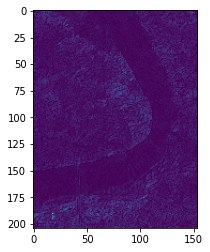

In [37]:
cD= np.maximum(morphed_img_pan1[0],morphed_img_ms1[0] )
plt.imshow(cD)

avg fusion rule on cA of MS and PAN

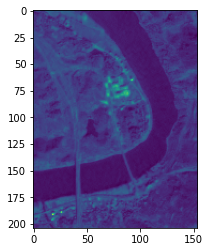

In [38]:
cA= (LL+LL1)/2
plt.imshow(cA)

IDWT

In [39]:
from pywt import idwt2
fused= pywt.idwt(cA,cD ,'db5', 'smooth')


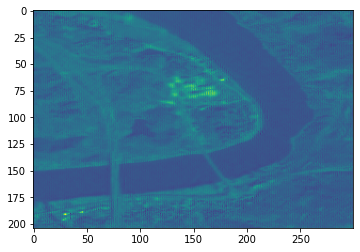

In [40]:
plt.imshow(fused)

MHT on PAN

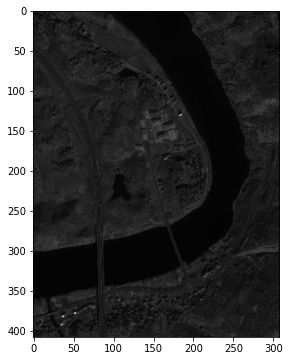

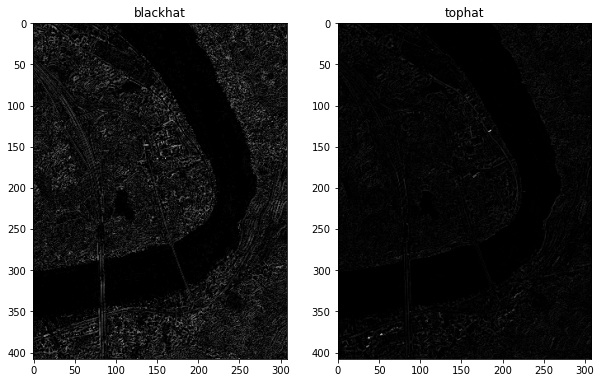

In [41]:
#@title
# Importing OpenCV
import cv2
filterSize =(3, 3)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_8.npy',None)
pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
plt.figure(figsize=(6,6))
plt.imshow(pan0, cmap='gray')

morphed_img1=[]
#input_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blackhat_img = cv2.morphologyEx(pan0,cv2.MORPH_BLACKHAT,kernel)
morphed_img1.append(blackhat_img)

morphed_img2=[]
#input_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
tophat_img = cv2.morphologyEx(pan0,cv2.MORPH_TOPHAT,kernel)
morphed_img2.append(tophat_img)


plt.figure(figsize=(10,9))

plt.subplot(121)
plt.title('blackhat')
plt.imshow( morphed_img1[0],cmap= 'gray')
plt.subplot(122)
plt.title('tophat')    
plt.imshow( morphed_img2[0],cmap='gray')



In [ ]:
#@title
morphed_img1[0].shape

(456, 404)

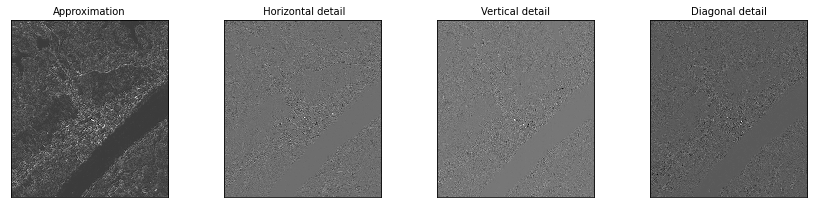

In [ ]:
#@title
# Load image
original = morphed_img1[0]
w='db5'

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, w)
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap='gray')
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

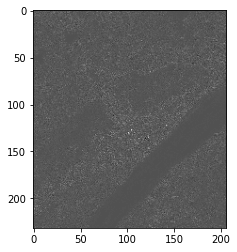

In [ ]:
#@title
lowPAN= np.maximum( LH, HL, HH)
plt.imshow(lowPAN,cmap='gray')

fusion of low coefficients of PAN and MS

In [ ]:
#@title
lowMS.shape

(208, 158)

In [ ]:
#@title
lowMS = cv2.resize(lowMS, (206,232 ))

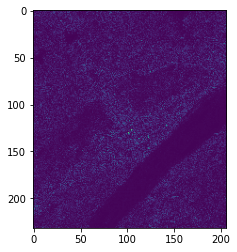

In [ ]:
#@title
low_fused_array= np.maximum(lowMS,lowPAN)
plt.imshow(low_fused_array)
plt.show()

fusion of high coeff of PAN and MS

In [ ]:
#@title
LL1 = cv2.resize(LL1, (206,232 ))

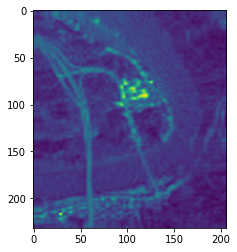

In [ ]:
#@title
high_fused_array= np.maximum(LL1,LL)
plt.imshow(high_fused_array)
plt.show()

IDWT

In [ ]:
#@title
from pywt import idwt2
fused= pywt.idwt(high_fused_array, low_fused_array, 'db2', 'smooth')


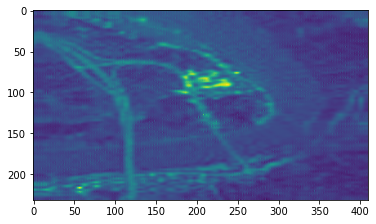

In [ ]:
#@title
plt.imshow(fused)

In [ ]:
entropy = skimage.measure.shannon_entropy(pan0)
print(entropy)

4.783737017067672


In [ ]:
entropy = skimage.measure.shannon_entropy(ms0)
print(entropy)

5.7585439190964385


In [42]:
entropy = skimage.measure.shannon_entropy(cA)
print(entropy)

14.939211882666394


In [ ]:
entropy = skimage.measure.shannon_entropy(high_fused_array)
print(entropy)

NameError: ignored

In [44]:
print("STD_ms", ms0.std())
print("STD_pan", pan0.std())
print("STD_fused", fused.std())
print("STD_fused", cA.std())





STD_ms 31.759618311782106
STD_pan 0.07077846432747813
STD_fused 0.06731626268392396
STD_fused 0.0871029977517828


In [45]:
#@title
from abc import abstractmethod
import numpy as np
from math import pi
from cv2 import cartToPolar, Sobel, CV_32F
from matplotlib.pyplot import imshow, title, show

class XideaPetrovicMetric():
    # xydeas_petrovic parameters
    # The constants Γ, κ , σ  and Γα, κα, σα determine 
    # the  exact  shape  of  the  sigmoid  functions  used  to  form  the  edge  strength  and  
    # orientation  preservation  values.
    def __init__(self, image1, image2, fusedImage) -> None:
        self.EPS = np.finfo(float).eps
        self.GAMMA1 = 1
        self.GAMMA2 = 1
        self.K1 = -10
        self.K2 = -20
        self.DELTA1 = 0.5
        self.DELTA2 = 0.75
        self.L = 1
        self.image1 = image1
        self.image2 = image2
        self.fusedImage = fusedImage

    def _sobel_edge_detection(self, image, verbose=False):
        sx = Sobel(image, CV_32F, 1, 0)
        sy = Sobel(image, CV_32F, 0, 1)

        if verbose:
            imshow(sx, cmap='gray')
            title("Horizontal Edge")
            show()

            imshow(sy, cmap='gray')
            title("Vertical Edge")
            show()

        return cartToPolar(sx, sy)

    def _strenght_n_orientation(self, image):
        #The first input is the source image, which we convert to float. 
        #The second input is the output image, but we'll set that to None as we want the function 
        # call to return that for us. 
        #The third and fourth parameters specify the minimum and maximum values 
        # you want to appear in the output, which is 0 and 1 respectively, 
        #and the last output specifies how you want to normalize the image.
        # What I described falls under the NORM_MINMAX flag.
        #image = normalize(image.astype('float'), None, 0.0, 1.0, NORM_MINMAX)  
        # Kernels for convolving over the images
        #flt1= [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
        #flt2= [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
        # 1) get the map Sobel operator
        #fuseX = filter2D(image, -1, flt1)
        #fuseY = filter2D(image, -1, flt2)
        #   EQUIVALENT TO:
        s_x, s_y = self._sobel_edge_detection(image)
        #fusex
        # A Sobel edge operator is applied to yield the edge strength G
        g = np.sqrt(s_x**2 + s_y**2)
        # Orientation α(n,m) information for each pixel p
        alpha = np.arctan(s_y / ( s_x + self.EPS))
        return (g, alpha)

    def _perceptual_loss(self, gA, gF, alphaA, alphaF):
        # If g o alpha are followed by an underscore are ment to be considered written in uppercase
        # The relative strength and orientation values of g_AF(n,m) and alpha_AF(n,m) of an input 
        # image A with respect to F are formed as:
        
        #x, y = gA.shape
        #g_AF = np.zeros((x,y))
        #for n in range(x):
        #    for m in range(y):
        #        if (gA[n][m]  > gF[n][m]):
        #            g_AF[n][m] = gF[n][m] / ( gA[n][m] + EPS)
        #        else:
        #            g_AF[n][m] = gA[n][m] / ( gF[n][m] + EPS)
        bmap0 = gA > gF
        bmap1 = gA < gF
        
        g_AF0 = np.divide(gF, ( gA + self.EPS))
        g_AF1 = np.divide(gA, ( gF + self.EPS))

        g_AF = np.multiply(bmap0, g_AF0) + np.multiply(bmap1, g_AF1)

        alpha_AF = np.abs( np.abs(alphaA - alphaF) - pi/2) / (pi/2)

        qG_AF = self.GAMMA1 / (1 + np.exp( self.K1 *(g_AF - self.DELTA1)))
        qalpha_AF = self.GAMMA2 / (1 + np.exp( self.K2 *(alpha_AF - self.DELTA2) ))
        # These are used to derive the edge strength and orientation preservation values
        # QgAF(n,m)  and  QαAF(n,m)  model  perceptual  loss  of  information  in  F,  in  terms  of  
        # how well the strength and orientation values of a pixel p(n,m) in A are 
        # represented in the fused image. 
        #
        # Edge  information preservation values are then defined as
        q_AF = qG_AF * qalpha_AF
        # with  0  ≤  Q AF(n,m)  ≤  1 .  A  value  of  0  corresponds  to  the  complete  loss  of  edge  
        # information, at location (n,m), as transferred from A into F. QAF(n,m)=1 indicates 
        # “fusion” from A to F with no loss of information. 
        return q_AF

    def calculate(self):
        # EDGE Strenght and orientation for each pixels of the input images
        gA, alphaA = self._strenght_n_orientation(self.image1)
        gB, alphaB = self._strenght_n_orientation(self.image2)
        gF, alphaF = self._strenght_n_orientation(self.fusedImage)
        
        self.q_AF = self._perceptual_loss(gA, gF, alphaA, alphaF)
        self.q_BF = self._perceptual_loss(gB, gF, alphaB, alphaF)
        #
        # In general edge preservation values which 
        # correspond to pixels with high edge strength, should influence normalised weighted  
        # performance metric QP more than 
        # those of relatively low edge strength.Thus, wA(n,m)=[gA(n,m)]^L and 
        # wB(n,m)=[gB(n,m)]^L where L is a constant.
        #
        self.wA = gA #np.linalg.matrix_power(gA, L)
        self.wB = gB #np.linalg.matrix_power(gB, L)

        self.r = ( gF < gA ) | ( gF < gB )
        self.bitmap_artifacts = (gF > gA) & (gF > gB)

        return self.metric() #hook
    
    @abstractmethod
    def metric(self):
        pass

class InformationPreservation(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        qP_ABF = sum( sum((self.q_AF * self.wA + self.q_BF * self.wB))) / sum ( sum((self.wA + self.wB)))
        return qP_ABF

class TotalFusionGain(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    def metric(self):
        # local exclusive information in F, Q_delta
        # quantifies the total amount of local
        # exclusive information across the fused image.
    
        q_delta = np.abs(self.q_AF - self.q_BF)
    
        # For locations with strong correlation between the inputs Q_delta 
        # will be small or zero, indicating no exclusive
        # information. Conversely, in areas where one of the
        # inputs provides a meaningful feature that is not present
        # in the other this quantity will tend towards 1.

        # The common information component for all locations across the fused image
        q_common = (self.q_AF + self.q_BF  - q_delta) / 2
        # ½ is introduced as common information is contained in both Q_AF and Q_BF

        # Local estimates of exclusive information
        # components of each input
        q_delta_AF = self.q_AF - q_common
        # is the proportion of useful information fused in F that exists only in A
        q_delta_BF = self.q_BF - q_common
        # is the proportion of useful information fused in F that exists only in B

        # These quantities represent effectively, local fusion gain 
        # achieved by fusing A and B with respect to each individual {A, B}.
        
        # TOTAL FUSION GAIN
        return sum( sum((q_delta_AF * self.wA + q_delta_BF * self.wB))) / sum ( sum((self.wA + self.wB)))

class FusionLossArtifact(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        # if gradient strength in F is larger than
        # that in the inputs, F contains artifacts; conversely, a
        # weaker gradient in F indicates a loss of input
        # information.
        loss = np.multiply(1 - self.q_AF, self.wA) + np.multiply(1 - self.q_BF, self.wB)
        loss = np.multiply(loss, self.r)
        loss = sum( sum(loss)) / sum ( sum((self.wA + self.wB)))

        #Artifacts calculation
        
        artifacts = 2 - self.q_AF - self.q_BF
        artifacts = np.multiply(self.bitmap_artifacts, artifacts)
        artifacts = sum( sum(artifacts)) / sum ( sum((self.wA + self.wB)))

        return (loss, artifacts)


In [48]:
ms0 = ms0[:,:,0]

In [53]:
cA = cv2.resize(cA, (308,408 ))

In [ ]:
ms0 = cv2.resize(ms0, (404,456 ))

In [50]:
pan0.shape

(408, 308)

In [51]:
ms0.shape

(408, 308)

In [52]:
cA.shape

(456, 404)

In [54]:
InformationPreservation(pan0.astype('float32'), ms0.astype('float32'), cA.astype('float32')).calculate()

0.1924553406903866

In [56]:
TotalFusionGain(pan0.astype('float32'), ms0.astype('float32'), cA.astype('float32')).calculate()

0.17787650589742

In [57]:
FusionLossArtifact(pan0.astype('float32'), ms0.astype('float32'), cA.astype('float32')).calculate()

(0.7820728339707781, 0.020563733301934083)

In [58]:
def PSNR(ms0, result1):
    r= np.array(result1)
    print(ms0.shape)
    
    mse = np.mean((ms0 - r) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
    print (psnr)

In [59]:
PSNR(ms0,cA)

(408, 308)


17.0729259507955

In [60]:
PSNR(pan0,cA)

(408, 308)


52.74288692980146

Text(0, 0.5, 'T2 signal bin')

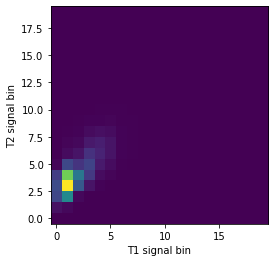

In [ ]:
hist_2d, x_edges, y_edges = np.histogram2d( ms0.ravel(),fused.ravel(),bins=20)
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

Text(0, 0.5, 'T2 signal bin')

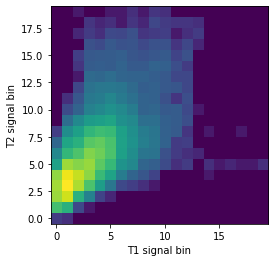

In [ ]:
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')

plt.xlabel('T1 signal bin')

plt.ylabel('T2 signal bin')


In [ ]:
def mutual_information(hgram):
  # Convert bins counts to probability values
  pxy = hgram / float(np.sum(hgram))
  px = np.sum(pxy, axis=1) # marginal for x over y
  py = np.sum(pxy, axis=0) # marginal for y over x
  px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
     # Now we can do the calculation using the pxy, px_py 2D arrays
  nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
  return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [ ]:
mutual_information(hist_2d)

0.32785730453940504

Text(0, 0.5, 'T2 signal bin')

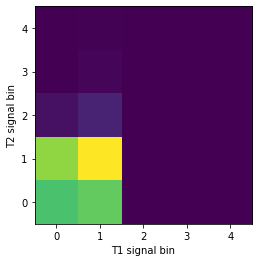

In [ ]:
hist_2d, x_edges, y_edges = np.histogram2d(pan0.ravel(),fused.ravel(),bins=5)
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

Text(0, 0.5, 'T2 signal bin')

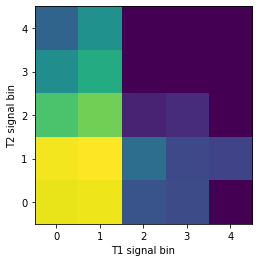

In [ ]:
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')

plt.xlabel('T1 signal bin')

plt.ylabel('T2 signal bin')

In [ ]:
mutual_information(hist_2d)

0.0033490182320116703